# Preliminary Results

## Load Libraries

In [1]:
## code to get rid of warnings
defaultW <- getOption("warn") 
options(warn = -1) 
##

library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(kableExtra)
library(knitr)
library(cowplot)

-- Attaching packages --------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'kableExtra'


The following object is masked from 'package:dplyr':

    group_rows




## Data Intake and Pre-Processing

First, we will read in the dataset. The code here assumes you've downloaded the dataset and placed them into a data folder. If you would like to run our code and follow along, please clone our GitHub repository [here](https://github.com/KevinSaigon/stat-201-project)

In [2]:
data <- read.csv(file = "data/athlete_events.csv")
# website says "Demonstrate that the dataset can be read from the web into R." - is local files okay? Ask on Monday

We will then do some pre-processing to get rid of any athlete whose age is is not known as well as filter out ones who did not win gold medals. 

The next step was then to only count first-time wins for multiple-time medal winners (i.e Michael Phelps). The code below essentially only keep the first occurrence of an athlete's ID, and since we sorted the dataframe by Year, this equates to the athlete's first time winning the gold medal.

In [3]:
processed_df <- data[order(data$Year),]  %>% 
    filter(!is.na(Age)) %>% # get rid of NA/Age
    filter(!is.na(Medal)) # we should get rid of anyone who didn't win a medal either - does NA in the medal mean they didn't win or they don't know
                            # also, let's decide if we care about bronze/silver as opposed to just looking at gold
#     filter(Medal == "Gold")

first_time_only <- processed_df[match(unique(processed_df$ID), processed_df$ID),] # only first time winners now, if they won a second time, it was excluded
    
head(first_time_only)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,12068,Arthur Charles Blake,M,24,NA,NA,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,"Athletics Men's 1,500 metres",Silver
2,12563,Conrad Helmut Fritz Bcker,M,25,NA,NA,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold
4,12929,John Mary Pius Boland,M,25,NA,NA,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Gold
6,16616,"Thomas Edmund ""Tom"" Burke",M,21,183,66,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's 100 metres,Gold
8,17492,Eugne Henri Callot,M,20,NA,NA,France,FRA,1896 Summer,1896,Summer,Athina,Fencing,"Fencing Men's Foil, Individual",Silver
9,18785,Demetrius Emmanuel Casdagli,M,23,NA,NA,Greece,GRE,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Silver


Next, we will split the dataset by their Season, the winter Olympics vs the summer Olympics

In [4]:
winter_df <- first_time_only %>% 
    filter(Season == "Winter")

summer_df <- first_time_only %>% 
    filter(Season == "Summer")

head(winter_df)
head(summer_df)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,391,Clarence John Abel,M,23,185,102,United States,USA,1924 Winter,1924,Winter,Chamonix,Ice Hockey,Ice Hockey Men's Ice Hockey,Silver
2,1341,Johan Petter hln (Andersson-),M,44,NA,NA,Sweden,SWE,1924 Winter,1924,Winter,Chamonix,Curling,Curling Men's Curling,Silver
3,3872,William Harding Anderson,M,22,NA,NA,Great Britain,GBR,1924 Winter,1924,Winter,Chamonix,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
4,4060,Georges Jules Andr,M,47,NA,NA,France,FRA,1924 Winter,1924,Winter,Chamonix,Curling,Curling Men's Curling,Bronze
5,5232,Thomas Alfred Arnold,M,22,NA,NA,Great Britain-1,GBR,1924 Winter,1924,Winter,Chamonix,Bobsleigh,Bobsleigh Men's Four/Five,Silver
6,5932,Alfred Aufdenblatten,M,26,NA,NA,Switzerland,SUI,1924 Winter,1924,Winter,Chamonix,Military Ski Patrol,Military Ski Patrol Men's Military Ski Patrol,Gold


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,12068,Arthur Charles Blake,M,24,NA,NA,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,"Athletics Men's 1,500 metres",Silver
2,12563,Conrad Helmut Fritz Bcker,M,25,NA,NA,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold
3,12929,John Mary Pius Boland,M,25,NA,NA,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Gold
4,16616,"Thomas Edmund ""Tom"" Burke",M,21,183,66,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's 100 metres,Gold
5,17492,Eugne Henri Callot,M,20,NA,NA,France,FRA,1896 Summer,1896,Summer,Athina,Fencing,"Fencing Men's Foil, Individual",Silver
6,18785,Demetrius Emmanuel Casdagli,M,23,NA,NA,Greece,GRE,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Silver


In [5]:
nrow(winter_df)

[1] 3658

## Calculations 

If we are assuming that this dataset is 100% accurate and thus represent that entire population of all Olympic participants, then we could consider the dataset a population, and thus uncertainty would be 0%. However, in reality, if we were trying to gather this dataset ourselves, it is extremely unlikely as well as unfeasible to collect so many data points. Realistically, we would take a sample of this population, so we will will take an initial sample of 3000

In [6]:
winter_sample <- winter_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

summer_sample <- summer_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

head(winter_sample)

ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
120549,Lyudmila Yevgenyevna Titova,F,21,176,64,Soviet Union,URS,1968 Winter,1968,Winter,Grenoble,Speed Skating,Speed Skating Women's 500 metres,Gold
76633,Andreas Matt,M,27,192,100,Austria,AUT,2010 Winter,2010,Winter,Vancouver,Freestyle Skiing,Freestyle Skiing Men's Ski Cross,Silver
64837,Ilya Aleksandrovich Kulik,M,20,179,74,Russia,RUS,1998 Winter,1998,Winter,Nagano,Figure Skating,Figure Skating Men's Singles,Gold
35490,Andrea Fischbacher,F,24,164,58,Austria,AUT,2010 Winter,2010,Winter,Vancouver,Alpine Skiing,Alpine Skiing Women's Super G,Gold
81556,Eugenio Monti,M,28,172,73,Italy-2,ITA,1956 Winter,1956,Winter,Cortina d'Ampezzo,Bobsleigh,Bobsleigh Men's Two,Silver
133002,Jan Jelle Ykema,M,24,181,79,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Men's 500 metres,Silver


From this, we can calculate our estimates of the mean for each season

In [7]:
winter_mean_estimate <- mean(winter_sample$Age)
summer_mean_estimate <- mean(summer_sample$Age)

print(paste("Winter Mean Estimtate:", winter_mean_estimate))
print(paste("Summer Mean Estimtate:", summer_mean_estimate))

[1] "Winter Mean Estimtate: 24.855"
[1] "Summer Mean Estimtate: 24.901"


## Sampling

Then, we'll perform bootstrapping or resampling without replacement to calculate uncertainty later on

In [8]:
winter_bootstrap <- winter_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)

summer_bootstrap <- summer_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)


head(summer_bootstrap)

replicate,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,67717,Georges Marcel Lecointe,M,26,NA,NA,France,FRA,1924 Summer,1924,Summer,Paris,Rowing,Rowing Men's Coxed Fours,Silver
1,99162,Jukka Matti Rauhala,M,25,172,62,Finland,FIN,1984 Summer,1984,Summer,Los Angeles,Wrestling,"Wrestling Men's Lightweight, Freestyle",Bronze
1,29304,Alfred Dompert,M,21,174,60,Germany,GER,1936 Summer,1936,Summer,Berlin,Athletics,"Athletics Men's 3,000 metres Steeplechase",Bronze
1,59173,Shahid Ali Khan,M,19,170,60,Pakistan,PAK,1984 Summer,1984,Summer,Los Angeles,Hockey,Hockey Men's Hockey,Gold
1,21141,Rodolfo Choperena Irizarri,M,31,NA,NA,Mexico,MEX,1936 Summer,1936,Summer,Berlin,Basketball,Basketball Men's Basketball,Bronze
1,36784,Bernard Wallis Franklin,M,22,NA,NA,Great Britain,GBR,1912 Summer,1912,Summer,Stockholm,Gymnastics,Gymnastics Men's Team All-Around,Bronze


Now, we will calculate the sample mean for each sample.

In [9]:
winter_resampled_means <- winter_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

summer_resampled_means <- summer_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

head(winter_resampled_means)
head(summer_resampled_means)
## TODO: CAN SOMEONE PLEASE FIND A WAY TO DISPLAY THESE TWO TABLES SIDE BY SIDE IT'S DRIVING ME NUTS

replicate,mean_age
<int>,<dbl>
1,25.055
2,24.919
3,24.799
4,24.938
5,24.845
6,24.923


replicate,mean_age
<int>,<dbl>
1,24.638
2,24.907
3,24.609
4,25.172
5,24.876
6,24.798


## Visualizations

Let's first remind ourselves of our calculated estimates

In [10]:
name <- c("Winter Mean Esimtate", "Summer Mean Estimate")
values <- c(winter_mean_estimate, summer_mean_estimate)

tab <- data.frame(name, values)
tab

name,values
<chr>,<dbl>
Winter Mean Esimtate,24.855
Summer Mean Estimate,24.901


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



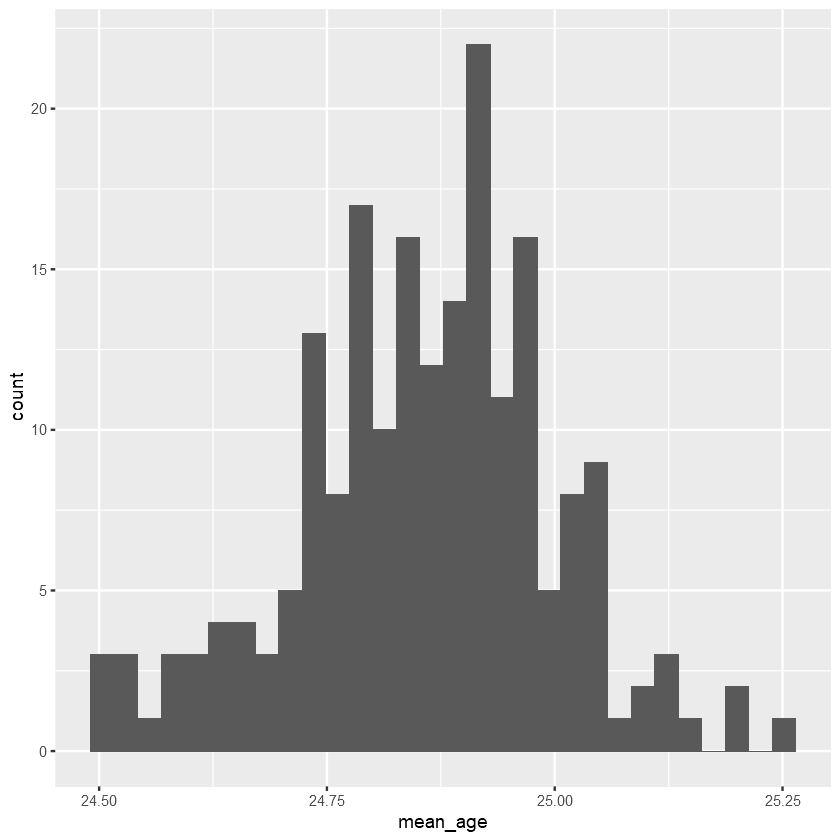

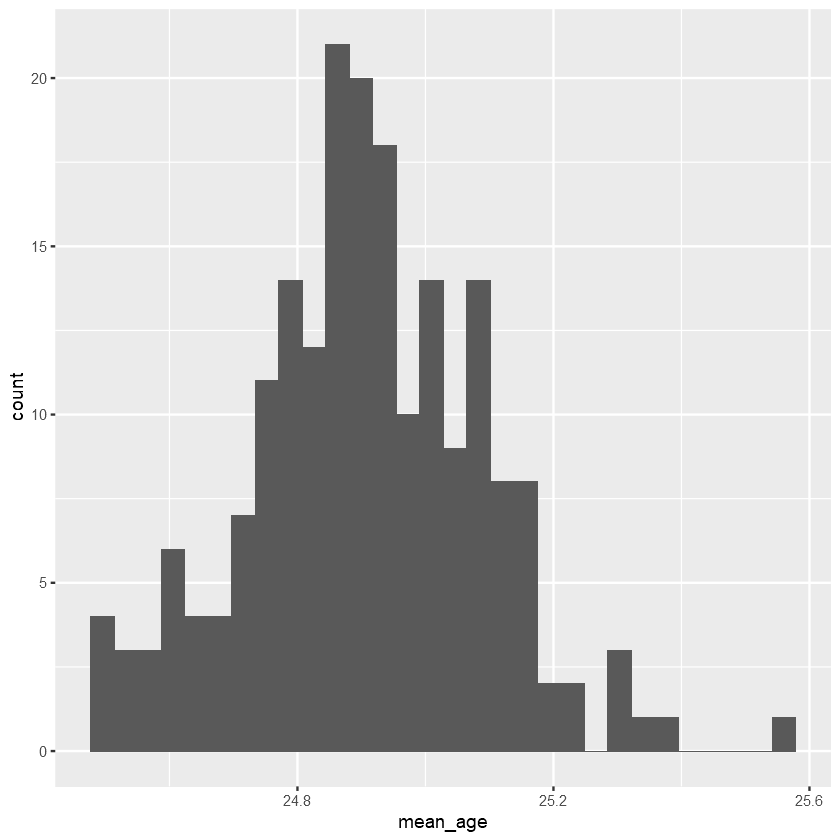

In [11]:
## TODO: tien can you basically plot the distribution of the samples above, then add all the fancy functions you did below
# play with the bins so you can get a better looking curve lmao
# any chance you can put the plots side by side so we don't have to scroll? Try it out if it doesn't work forget about it
winter_resampled_means  %>% 
    ggplot(aes(x = mean_age)) + 
    geom_histogram()

summer_resampled_means  %>% 
    ggplot(aes(x = mean_age)) + 
    geom_histogram()

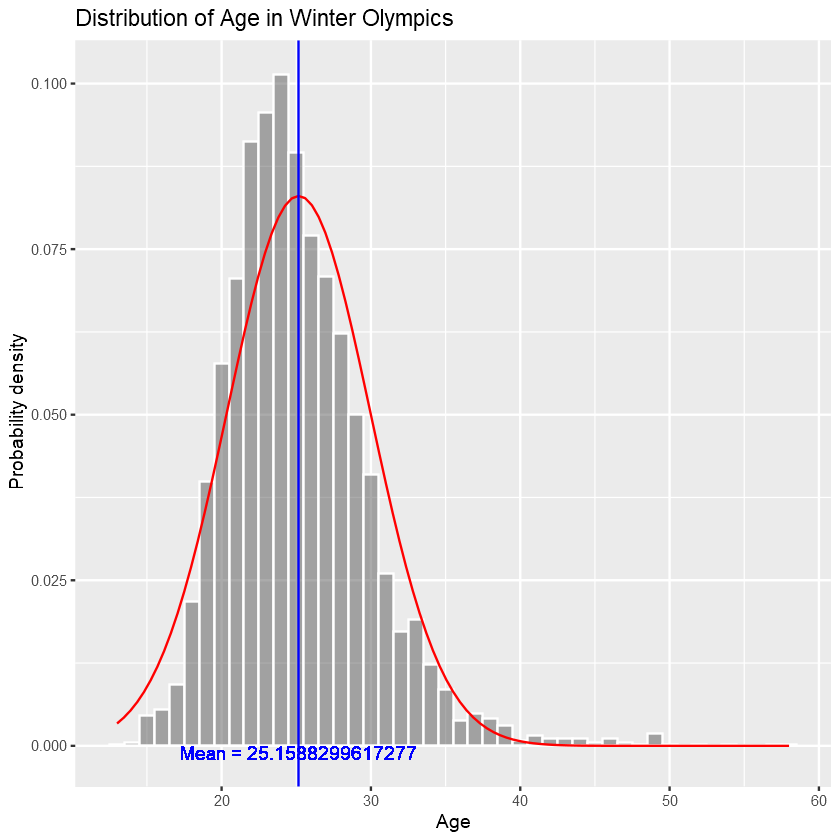

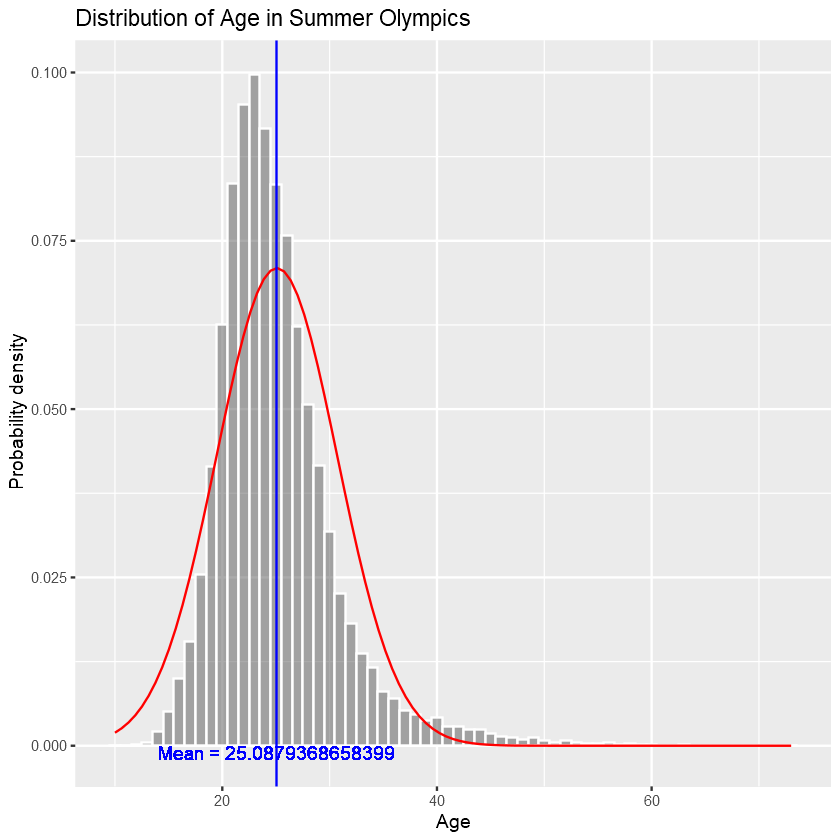

In [12]:
# histograms layered with Gaussian distribution curve, the height of each bar rerpresent the count.
# since it is layered with the bell curve, the count also represent the repsective probability.


winter_df %>%
        ggplot(aes(x=Age)) +
        geom_histogram(aes(y=..density..),binwidth=1, color="white", alpha=0.5) +
        stat_function(fun=dnorm, color="red", args=list(mean=mean(winter_df$Age), 
                                                        sd=sd(winter_df$Age))) +
        geom_vline(xintercept = mean(winter_df$Age), color="blue") +
        geom_text(aes(x = mean(winter_df$Age), 
                      y=-0.001, 
                      label=paste0("Mean = ", mean(winter_df$Age))),
                  color="blue") +
        labs(x="Age", y="Probability density", title="Distribution of Age in Winter Olympics")

summer_df %>%
        ggplot(aes(x=Age)) +
        geom_histogram(aes(y=..density..),binwidth=1, color="white", alpha=0.5) +
        stat_function(fun=dnorm, color="red", args=list(mean=mean(summer_df$Age), 
                                                        sd=sd(summer_df$Age))) +
        geom_vline(xintercept = mean(summer_df$Age), color="blue") +
        geom_text(aes(x = mean(summer_df$Age), 
                      y=-0.001, 
                      label=paste0("Mean = ", mean(summer_df$Age))),
                  color="blue") +
        labs(x="Age", y="Probability density", title="Distribution of Age in Summer Olympics")
